<a href="https://colab.research.google.com/github/isismeira/identificacao_melanoma_cnns/blob/main/diagnostico_de_melanoma_com_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de sinais de pele para diagnóstico de melanoma através de Redes Neurais Convolucionais (CNNs)

***Contextualização***: O câncer de pele é o tipo de câncer mais comum no Brasil e no mundo, e se desenvolve quando há um crescimento anormal e descontrolado das células da pele, geralmente causado pela exposição excessiva à radiação ultravioleta. Existem diferentes tipos de câncer de pele, sendo os mais comuns o carcinoma basocelular, o carcinoma espinocelular e o melanoma, sendo este último o mais perigoso.O melanoma pode se espalhar rapidamente para outros órgãos e causar metástases, sendo potencialmente fatal. Uma forma de observar um possível indicador de câncer de pele, é através do monitoramento de sinais na pele, que por características como tamanho, formato e cor, podem ser indício de câncer:

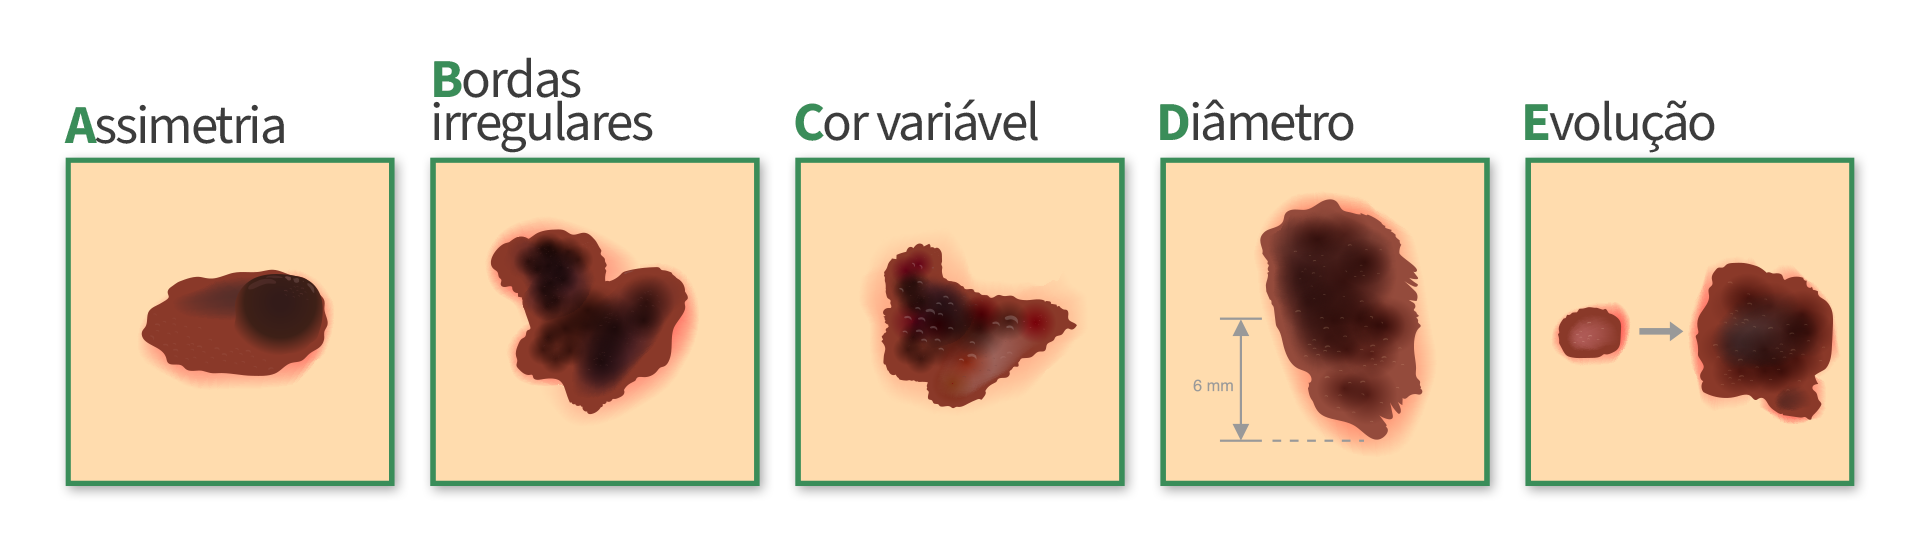



---



***Objetivo***: Desenvolver uma *Rede Neural Convolucional (CNN)* capaz de realizar uma tarefa de classificação binária à partir da entrada de uma nova imagem de um sinal de pele e classificar esse sinal como benigno (0) ou maligno (1).



---



***Arquitetura da rede neural:***

Como a tarefa é uma classificação binária, a arquitetura foi projetada com:

* Camadas Convolucionais:

 * 3 camadas convolucionais com filtros crescentes (32, 64, 128) e kernel 3x3.

 * Função de ativação ReLU em todas as camadas convolucionais para introduzir não-linearidade.

 * Cada camada é seguida por uma camada de MaxPooling 2x2 para redução dimensional.

* Estrutura de Redução Progressiva:

 * A arquitetura segue um padrão de blocos convolucionais + pooling, reduzindo progressivamente as dimensões espaciais enquanto aumenta a profundidade (número de filtros).

* Camada de Achatamento (Flatten):

 * Transforma os mapas de características 3D em um vetor 1D para conexão com as camadas densas.

* Camadas Densas (Fully Connected):

 * 1 camada oculta densa com 128 neurônios e ativação ReLU.

 * Dropout de 50% para regularização e prevenção de overfitting.

* Camada de Saída:

 * 1 neurônio de saída (para classificação binária).

 * Função de ativação sigmoid (adequada para problemas binários).

 * Função de perda: binary_crossentropy (entropia cruzada binária).

* Características Específicas:

 * Input shape: (224, 224, 3) - projetada para processar imagens coloridas RGB de 224x224 pixels.

 * A arquitetura aumenta progressivamente os filtros (32→64→128) enquanto reduz as dimensões espaciais via pooling, capturando padrões hierárquicos.

 * Dropout adicionado para melhor generalização em problemas complexos



---



***Dataset utilizado***: [Melanoma Skin Cancer Dataset of 10000 Images
](https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/data), retirado do Kaggle. A origem dessas imagens vem do [ISIC ARCHIVE](https://www.isic-archive.com/) *(The International Skin Imaging Collaboration​)* que é um grande arquivo de imagens de pele de acesso público que serve como um recurso  para ensino, pesquisa e desenvolvimento e teste de algoritmos de inteligência artificial de diagnóstico.


## Pré-processamento

In [52]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil

!rm -rf /content/train /content/test  # limpa se já existir
shutil.copytree('/content/drive/MyDrive/melanoma/train', '/content/train')
shutil.copytree('/content/drive/MyDrive/melanoma/test', '/content/test')

train_dir = '/content/train'
test_dir = '/content/test'

# limpa possíveis subpastas ocultas
for pasta in os.listdir(train_dir):
    caminho = os.path.join(train_dir, pasta)
    if pasta.startswith('.') and os.path.isdir(caminho):
        shutil.rmtree(caminho)
        print(f"Removido: {caminho}")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

AUGMENTATION = True

if AUGMENTATION:
    train_datagen = ImageDataGenerator( # treino com augmentation
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2]
    )
else:
    train_datagen = ImageDataGenerator( # treino sem augmentation
        rescale=1./255,
        validation_split=0.2
    )

# validação (sem augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# testes (sem augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# geradores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Classes detectadas:", train_generator.class_indices)

Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Classes detectadas: {'benign': 0, 'malignant': 1}


Observando as imagens após o pré-processamento...

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_imagens(generator):
  imagens, labels = next(generator)
  # Mostra as 9 primeiras imagens com suas classes
  plt.figure(figsize=(10, 10))
  for i in range(9):
      plt.subplot(3, 3, i+1)
      plt.imshow(imagens[i])
      plt.title(f'Classe: {"malignant" if labels[i] else "benign"}')
      plt.axis('off')
  plt.tight_layout()
  plt.show()


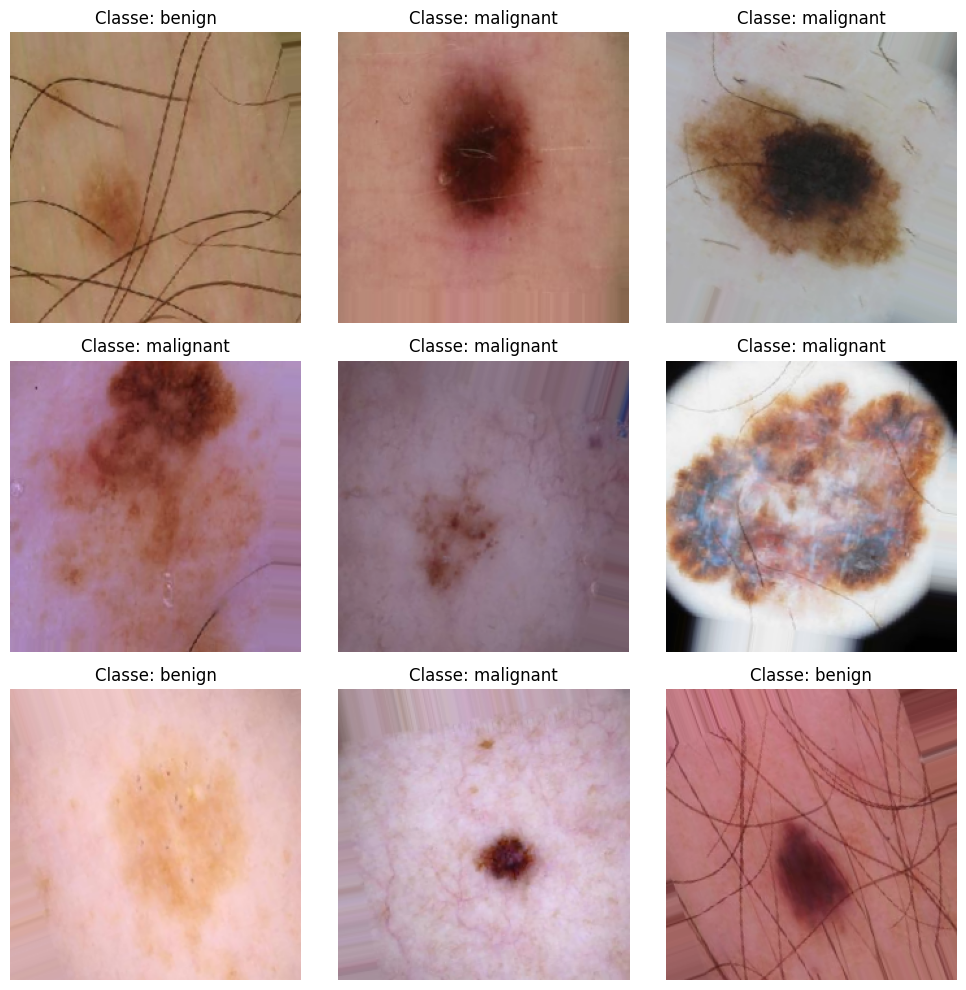

In [54]:
plot_imagens(train_generator) # imagens do conjunto de treino

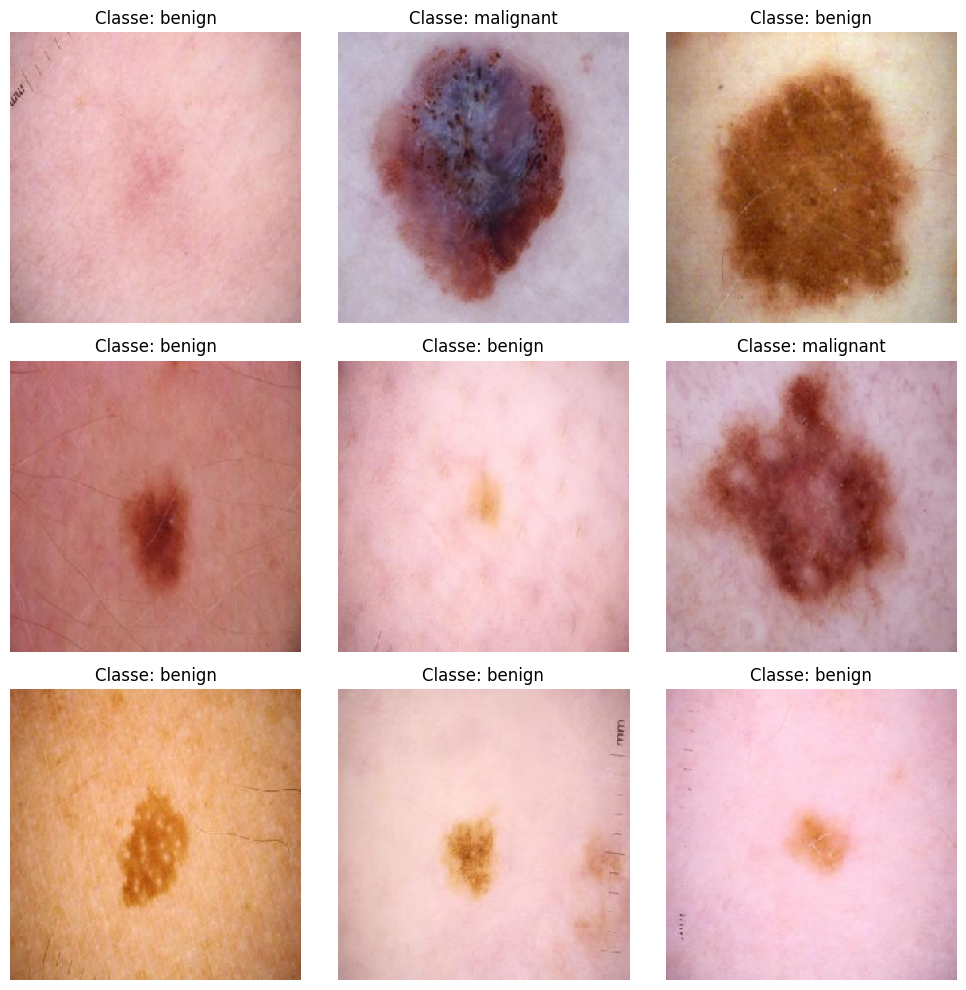

In [55]:
plot_imagens(val_generator) # imagens do conjunto de validação

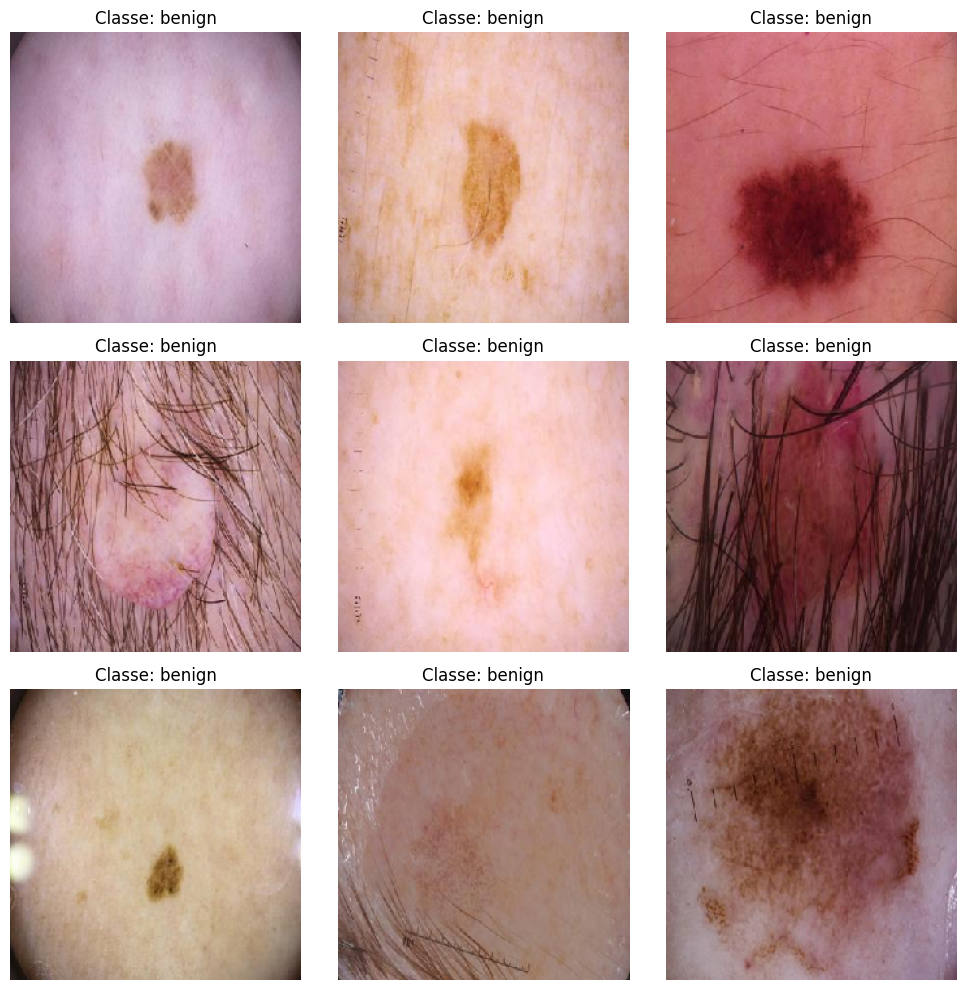

In [56]:
plot_imagens(test_generator) # imagens do conjunto de teste

## Modelo de Rede Neural Convolucional (CNN) personalizado

In [57]:
modelo_custom = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


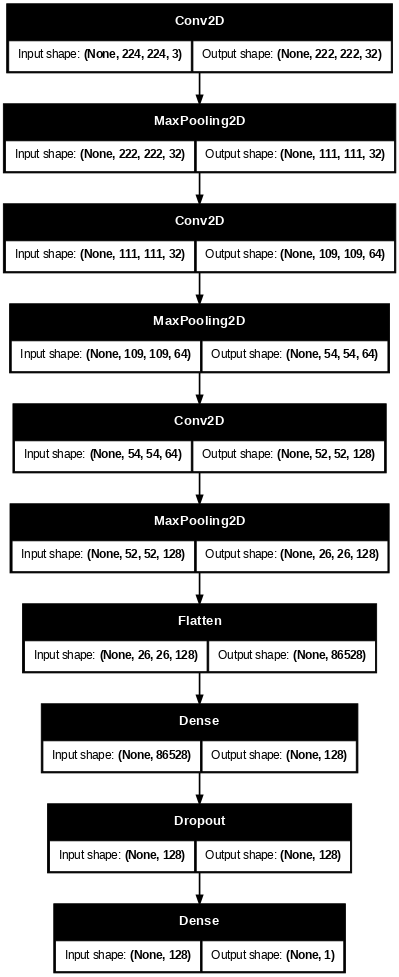

In [58]:
tf.keras.utils.plot_model(modelo_custom, "arquitetura_do_modelo_custom.png", show_shapes=True, dpi=60)

### Compilação

In [59]:
from tensorflow.keras.metrics import Precision, Recall # para utilizar as métricas de precisão e revocação

modelo_custom.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

### Treinando e avaliando o modelo

In [60]:
historico_custom = modelo_custom.fit(
    train_generator,
    validation_data=val_generator,
    epochs = 10,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 113s 456ms/step - accuracy: 0.6880 - loss: 0.6055 - precision_7: 0.7478 - recall_7: 0.5381 - val_accuracy: 0.8319 - val_loss: 0.4028 - val_precision_7: 0.9130 - val_recall_7: 0.7177
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 108s 449ms/step - accuracy: 0.8353 - loss: 0.3944 - precision_7: 0.8550 - recall_7: 0.7823 - val_accuracy: 0.8511 - val_loss: 0.3438 - val_precision_7: 0.9107 - val_recall_7: 0.7644
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 111s 461ms/step - accuracy: 0.8575 - loss: 0.3519 - precision_7: 0.8894 - recall_7: 0.8004 - val_accuracy: 0.8683 - val_loss: 0.3279 - val_precision_7: 0.8415 - val_recall_7: 0.8936
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 108s 449ms/step - accuracy: 0.8591 - loss: 0.3732 - precision_7: 0.8718 - recall_7: 0.8242 - val_accuracy: 0.8740 - val_loss: 0.3101 - val_precision_7: 0.8889 - val_recall_7: 0.8426
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 109s 450ms/step - accuracy: 0.8628 - loss: 0.3325 - precision_7: 0.8906 

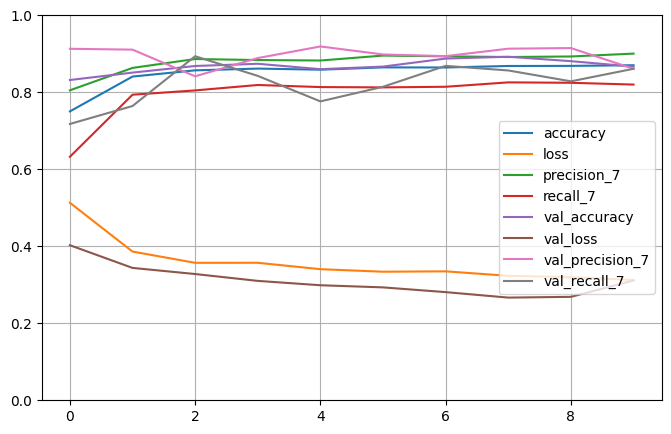

In [61]:
import pandas as pd

pd.DataFrame(historico_custom.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [83]:
from sklearn.metrics import classification_report

Y_pred = modelo_custom.predict(test_generator)
y_pred = (Y_pred > 0.4).astype("int").flatten() # diminuindo o limiar para aumentar o recall

print(classification_report(test_generator.classes, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       500
           1       0.88      0.90      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



***Observação***: Em aplicações médicas, revocação (recall) é frequentemente mais importante que precisão, pois é melhor ter falsos positivos (benignos classificados como melanoma) do que falsos negativos (melanomas não detectados). Por isso diminui o limiar para 0.4, para aumentar o recall e obter menos falsos negativos



In [84]:
from sklearn.metrics import accuracy_score
print("Acurácia final:", accuracy_score(test_generator.classes, y_pred))

Acurácia final: 0.892


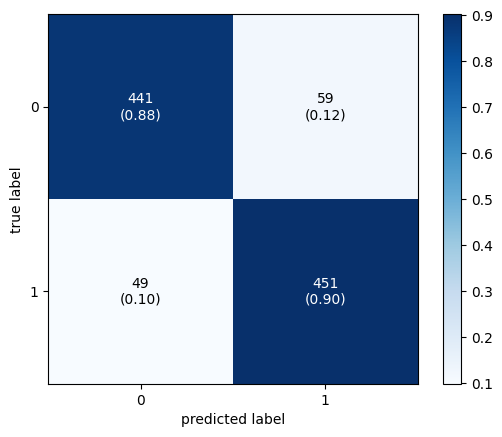

In [85]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

confusao = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(conf_mat=confusao,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()


### Analisando os erros cometidos pelo modelo

In [86]:
y_true = test_generator.classes

falsos_positivos = np.where((y_true == 0) & (y_pred == 1))[0]
falsos_negativos = np.where((y_true == 1) & (y_pred == 0))[0]

file_paths = np.array(test_generator.filepaths)
fp_paths = file_paths[falsos_positivos]
fn_paths = file_paths[falsos_negativos]


In [87]:
import matplotlib.image as mpimg

def plot_erro_imagens(paths, titulo, n=9):
    plt.figure(figsize=(10,10))
    for i in range(min(n, len(paths))):
        plt.subplot(3, 3, i+1)
        img = mpimg.imread(paths[i])
        plt.imshow(img)
        plt.title(os.path.basename(paths[i]))
        plt.axis('off')
    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout()
    plt.show()

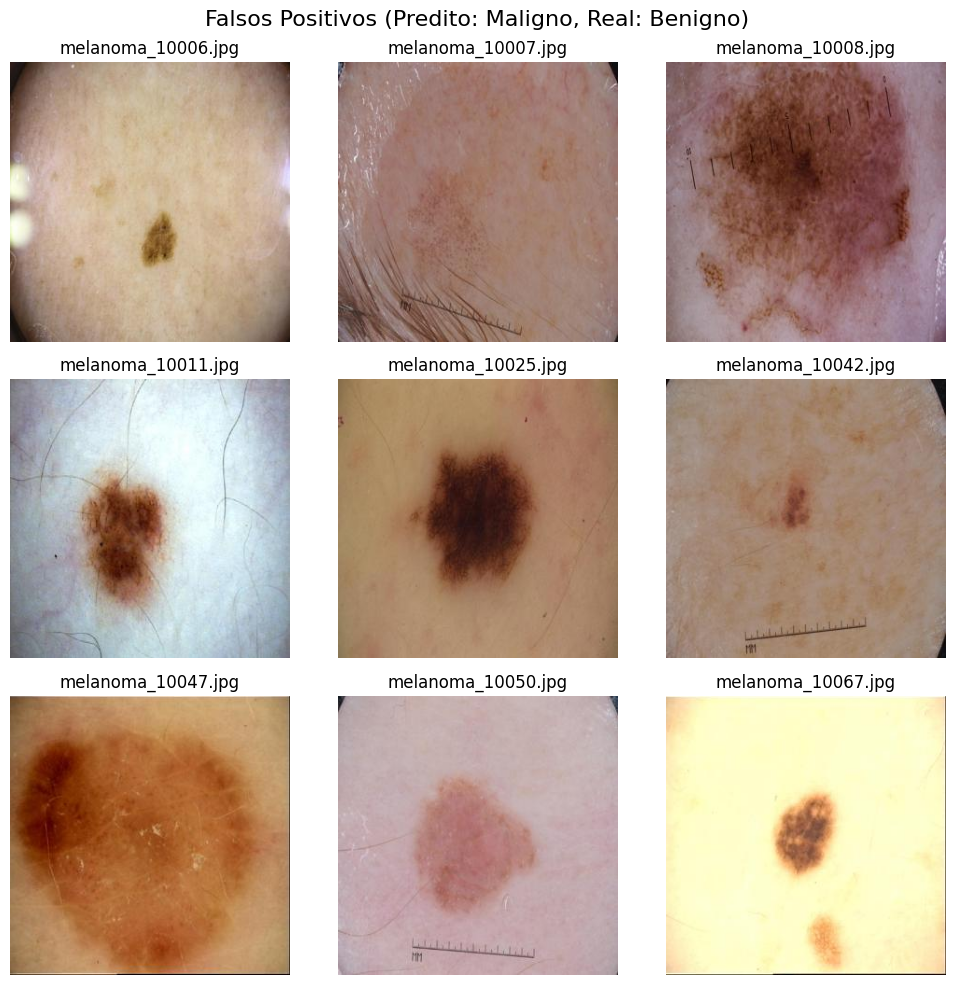

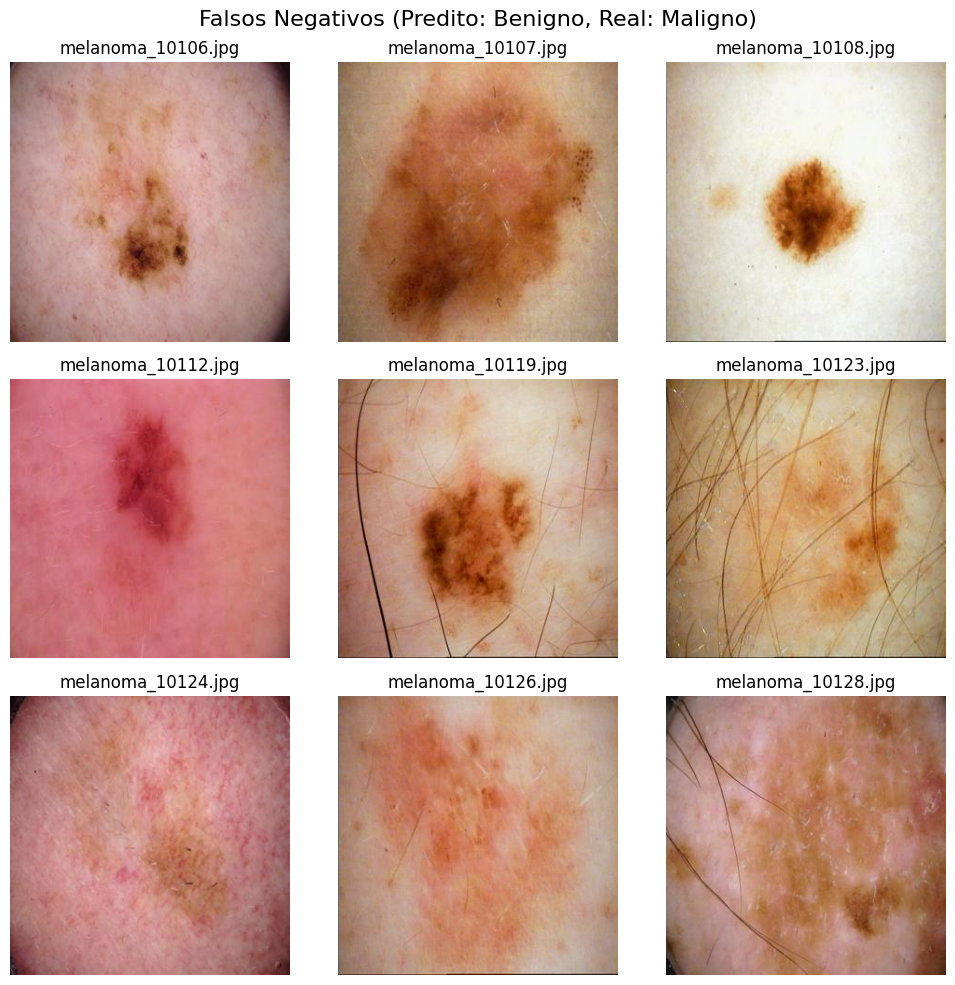

In [88]:
plot_erro_imagens(fp_paths, "Falsos Positivos (Predito: Maligno, Real: Benigno)")
plot_erro_imagens(fn_paths, "Falsos Negativos (Predito: Benigno, Real: Maligno)")

***Falsos Positivos***: A maioria das imagens classificadas errôneamente como maligno de fato levantam uma suspeita clara por via ocular, já que os sinais possuem bordas irregulares, tem um diâmetro grande e mudança de cor. Em um cenário médico, provavelmente esses sinais seriam removidos da pele por precaução e somente após uma biópsia seria constatado que esse sinais são benignos

***Falsos Negativos***: Algumas imagens classificadas errôneamente como benignas possuem um padrão de não serem sinais claramente delimitados, o que pode ter causado um problema durante a classificação da CNN